# Heart Rate Estimation

Seismocardiography ([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure the Heart Rate (HR) and Respiratory Rate (RR) with a detector positioned above the sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography ([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with a combination of both an accelerometer and a gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., the accelerometer platform can be mounted under the slats of the bed).   
  
MuSe (Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provided by [221e](https://www.221e.com). In the context of this project, it allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the heart rate of an healthy subject, given the linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

The study must be performed on two datasets: the first is the compulsory one (`center_sternum.txt`), while the second is left at the discretion of the group, among those made available for the assignment.

*Remember that normal heart rate is around [40-100] bpm.*


## Data

The data is provided in `.txt` files. During this study, two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* `center_sternum.txt`: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

* `1_Stave_supine_static.txt`: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* `2_Mattress_supine.txt`: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* `3_Subject_sitting_chair.txt`: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* `4_Chest_sweater.txt`: Sensor placed on the subject chest directly on a sweater. 
* `5_Under_chair.txt`: Subject sitting on a chair, sensor placed under the seat of the chair. 

All `.txt` files have 16 columns, containing: 

* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(`config_1.txt` for the first measurement, and in `config_5.txt` for the other measurement).
 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import linalg,fftpack
import seaborn as sns


SSSFile = "data/1_Stave_supine_static.txt"
MSFile = "data/2_Mattress_supine.txt"
SSCFile = "data/3_Subject_sitting_chair.txt"
CWFile = "data/4_Chest_sweater.txt"
UCFile = "data/5_Under_chair.txt"
CSFile = "data/center_sternum.txt"

FILES = [SSSFile,MSFile,SSCFile,CWFile,UCFile,CSFile]

CONFIG_1 = "config/config_1.txt"
CONFIG_5 = "config/config_5.txt"

In [4]:
# CONFIG 1
# Date:				13-12-2019
# Device: 		Muse_2128 v2 BC
# Configuration:		500 dps, 2 g, 12 G, 100 g, High Resolution, 200 Hz

# X, Y, Z, offset (if exists)
gyroCalibration_1 = np.array([-2.242224, 2.963463, -0.718397])
accCalibration_1 = np.array(
    [
        [1.000966, -0.002326418, -0.0006995499, -3.929942],
        [-0.002326379, 0.9787045, -0.001540918, -13.74679],
        [-0.0006995811, -0.001540928, 1.00403, 60.67546],
    ]
)
magCalibration_1 = np.array(
    [
        [0.9192851, -0.02325168, 0.003480837, -95.67974],
        [-0.02325175, 0.914876, 0.004257396, -244.9142],
        [0.003481006, 0.004257583, 0.8748001, 17.71132],
    ]
)

# CONFIG 5
# Date:				16/04/2019-17/04/2019
# Device: 		Muse_2168 v2 BC
# Configuration:		4000 dps, 2 g, 12 G, 100 g, High Resolution, 100 Hz

# X, Y, Z, offset (if exists)
gyroCalibration_5 = np.array([-2.804399, 1.793105, 0.3411708])

accCalibration_5 = np.array(
    [
        [1.002982, 9.415505e-05, 0.004346743, 3.602701],
        [9.04459e-05, 1.002731, -0.001444198, -20.96658],
        [0.004346536, -0.001444751, 1.030587, 54.97186],
    ]
)

magCalibration_5 = np.array(
    [
        [1.013437, -0.04728858, -0.001861475, -150.4098],
        [-0.04728862, 1.004832, 0.008222118, 74.62431],
        [-0.001861605, 0.008221965, 0.9439077, 630.9805],
    ]
)

In [5]:
metrics = ["Acc","Gyro","Magn"]
axes = ["X","Y","Z"]
acc = ["Acc" + axe for axe in axes]
gyro = ["Gyro" + axe for axe in axes]
magn = ["Magn" + axe for axe in axes]

1. Data preparation:

    1.1. Load the txt files and select only the columns you are interested in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    


In [6]:
def createDataFrame(iFile):
    oDataFrame = pd.read_csv(iFile, delimiter="\t")
    return oDataFrame

def setGyroValues(ioDataFrame,iGyroValues):
    gyroCols = np.array(["Gyro"+axe for axe in ["X","Y","Z"]])
    ioDataFrame[gyroCols] *= iGyroValues
    return ioDataFrame

def setValues(ioDataFrame,iValues,iCol):
    valuesCols = np.array([iCol+axe for axe in ["X","Y","Z"]])
    setting = iValues[:,:3]
    offset = iValues[:,3]
    ioDataFrame[valuesCols] = np.dot(ioDataFrame[valuesCols],setting)+offset
    return(ioDataFrame)

dataFrame = createDataFrame(CSFile)
print(dataFrame.head())


   Log Mode  Log Freq   Timestamp     AccX     AccY    AccZ      GyroX  \
0         5       200  1576222772  947.086  435.662  70.638  -6.824428   
1         5       200  1576222772  969.168  387.777  88.877   6.183206   
2         5       200  1576222772  989.603  380.335  78.751  11.709920   
3         5       200  1576222772  954.894  418.033  88.328  17.877860   
4         5       200  1576222772  972.096  427.732  99.857  25.221370   

       GyroY     GyroZ  MagnX  MagnY  MagnZ        qw        qi        qj  \
0 -14.244280  1.404580   -454   -490   -178  0.792622  0.254952 -0.553850   
1 -12.290080 -7.969466   -454   -490   -177  0.736461  0.275124 -0.617969   
2  -4.961832 -7.450382   -454   -490   -177  0.729465  0.275246 -0.626118   
3   2.519084 -5.984733   -454   -492   -176  0.723413  0.277200 -0.632221   
4   5.404580  4.015267   -454   -492   -176  0.721948  0.280007 -0.632679   

         qk  
0 -0.000031  
1  0.006806  
2  0.009827  
3  0.011383  
4  0.010193  


We reminder the different variables present in the dataframe :
* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

`Log Mode` and `Log Freq` are constant, so there is no need to study them.
As we study the MuSe on the center of the sternum, while the subject is lying on each side staticly, we don't have to consider the orientation of the MuSe system we can consider as identic all the long of the mesurement, which means there is no need to study `qw`, `qi`, `qj` and `qk`.
We can suppose it's interesting to study `Acc`, `Gyro` and `Magn`, for $X$, $Y$ and $Z$ axes.

In [33]:
dataFrame = dataFrame.loc[:, "Timestamp":"MagnZ"]

As we sutdy the [center_sternum.txt](data/center_sternum.txt) file, we have to consider the [config_1.txt](config/config_1.txt) file to calibrate the MuSe system, according to the different values of calibration.

In [34]:
dataFrame = setGyroValues(dataFrame,gyroCalibration_1)
dataFrame = setValues(dataFrame,accCalibration_1,"Acc")
dataFrame = setValues(dataFrame,magCalibration_1,"Magn")

1. Data preparation:

    1.2. Plot selected data as a function of time and choose a proper time window over which to perform the analysis. Pay attention on the time representation and the measurement unit.

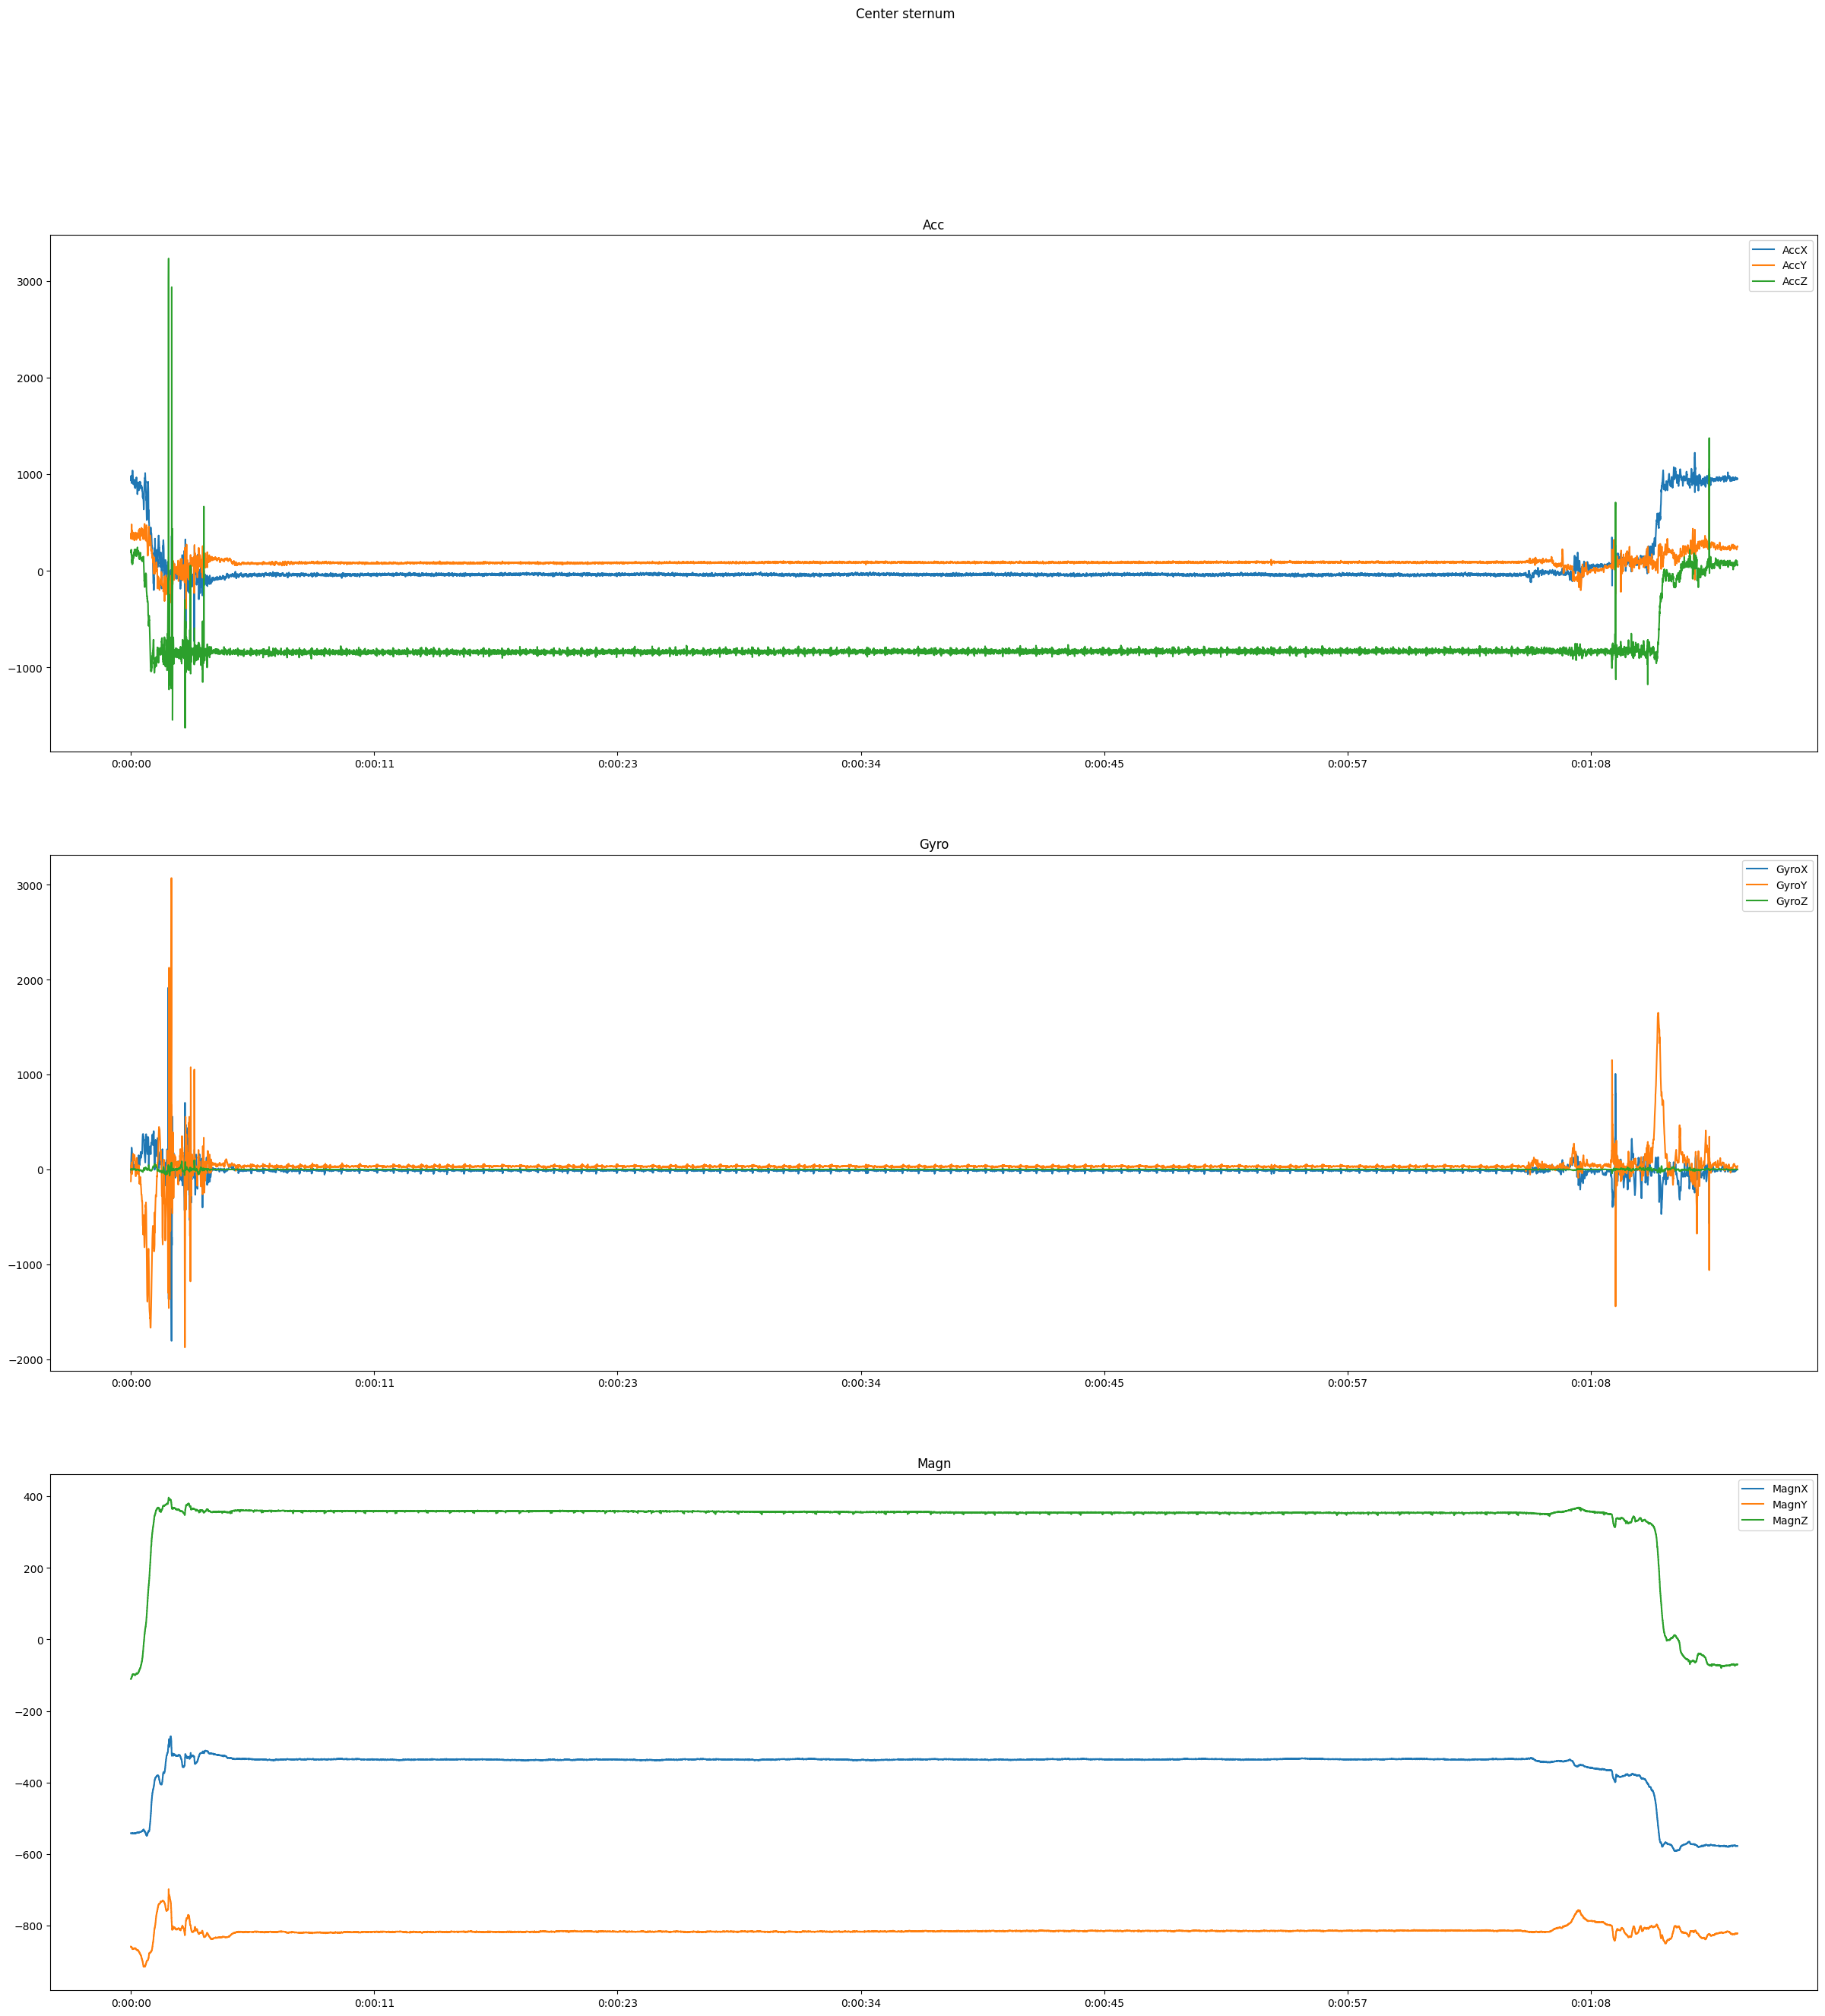

In [35]:
def ticks(value, _):
    if (value >= 0) & (value < len(dataFrame)):
        ticks = datetime.fromtimestamp(
            dataFrame["Timestamp"][value]
        ) - datetime.fromtimestamp(dataFrame["Timestamp"][0])
        return ticks


def graphDataFrame(iDataFrame,iTitle):
    values = np.arange(iDataFrame["Timestamp"].index.min(), iDataFrame["Timestamp"].index.max()+1, 1)

    figure, axs = plt.subplots(3, figsize=(30, 30))
    figure.suptitle(str(iTitle))

    for index, metric in enumerate(metrics):
        metricAxe = np.array([metric + axe for axe in axes])
        axs[index].plot(values, iDataFrame[metricAxe], label=metricAxe)
        axs[index].legend()
        axs[index].xaxis.set_major_formatter(plt.FuncFormatter(ticks))
        axs[index].set_title(metric)


graphDataFrame(dataFrame,"Center sternum")

We can observe some parasit noises in the beginning and the end of each signal. This noise can have severals origins so we decide to not consider these parts of the graphics.\
To drop these parts, we can take only graphics values betwen 0:00:11 and 0:01:08 approximatively. These values correspond to index between 1500 and 14000.\
Following graphes are the clean parts.

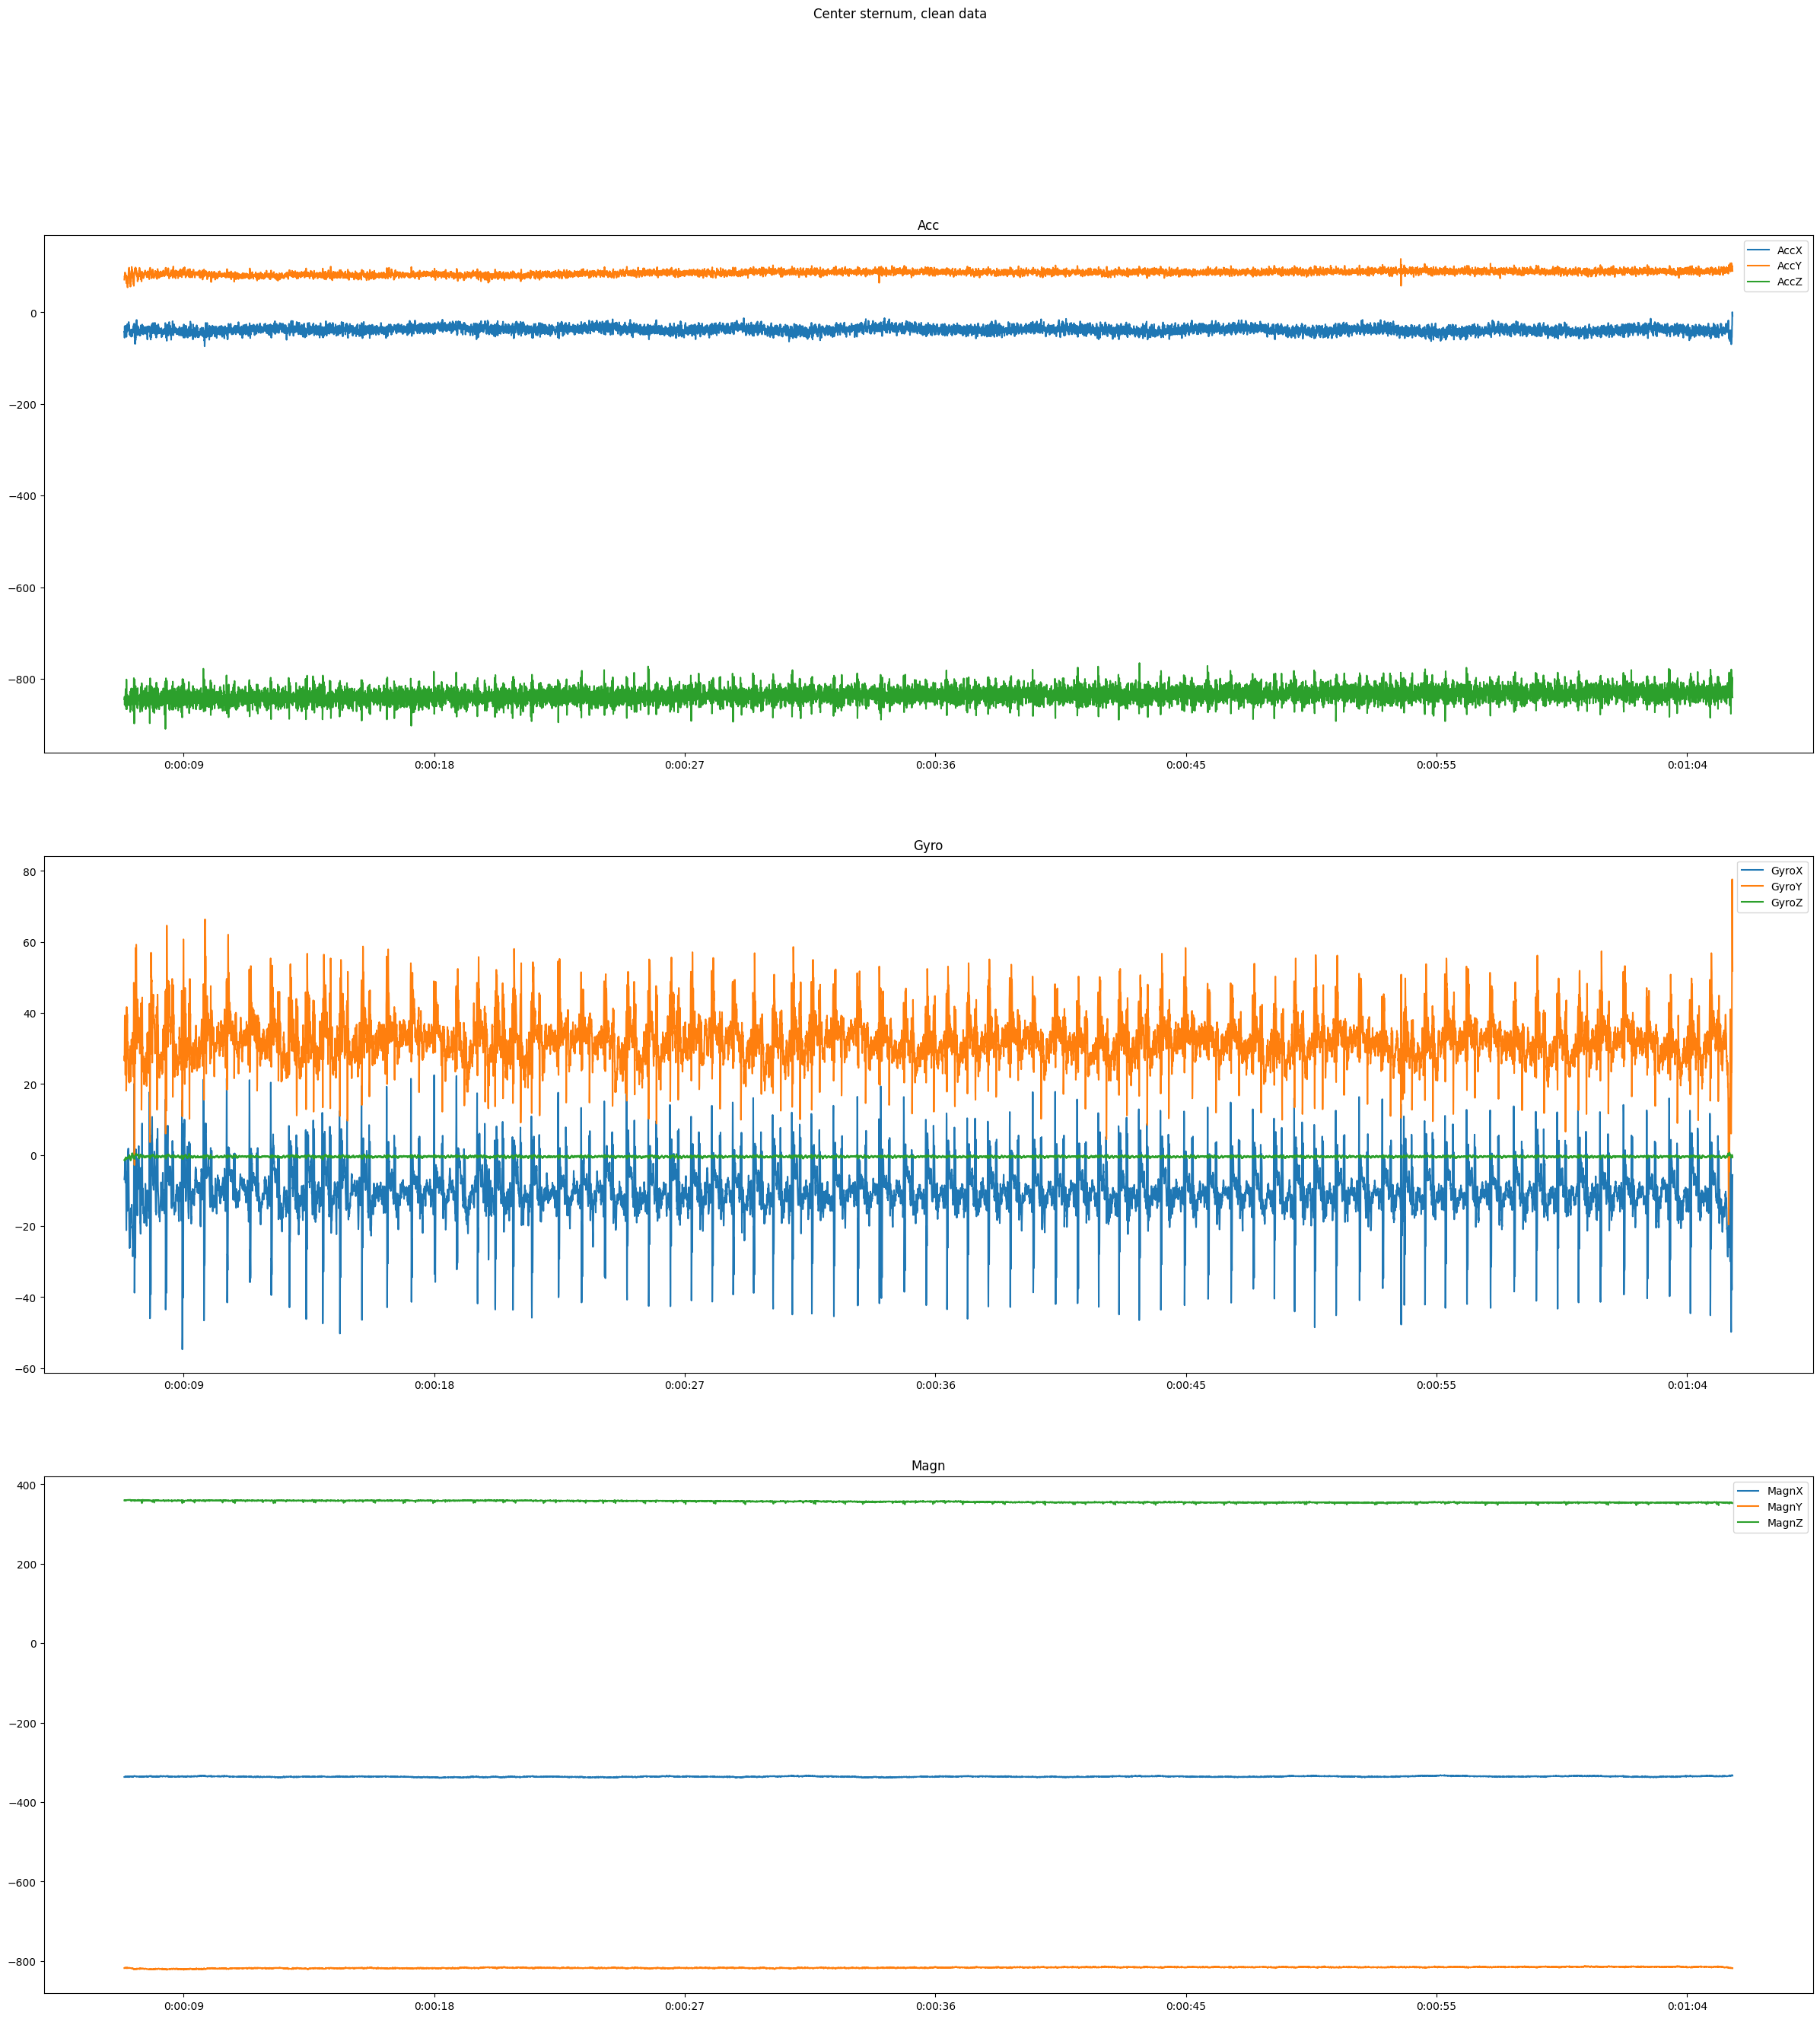

In [36]:
dataFrameCopy = dataFrame.copy()
indexMin = dataFrameCopy["Timestamp"].iloc[1400]
indexMax = dataFrameCopy["Timestamp"].iloc[14500]
dataFrameCopy = dataFrameCopy[(dataFrameCopy["Timestamp"]>indexMin)&(dataFrameCopy["Timestamp"]<indexMax)]
graphDataFrame(dataFrameCopy, "Center sternum, clean data")

1. Data preparation:

    1.3. In order to do a proper job, decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.

In a first time, it could be great to see the different correlation between each couple of axes, for each metric we kept.

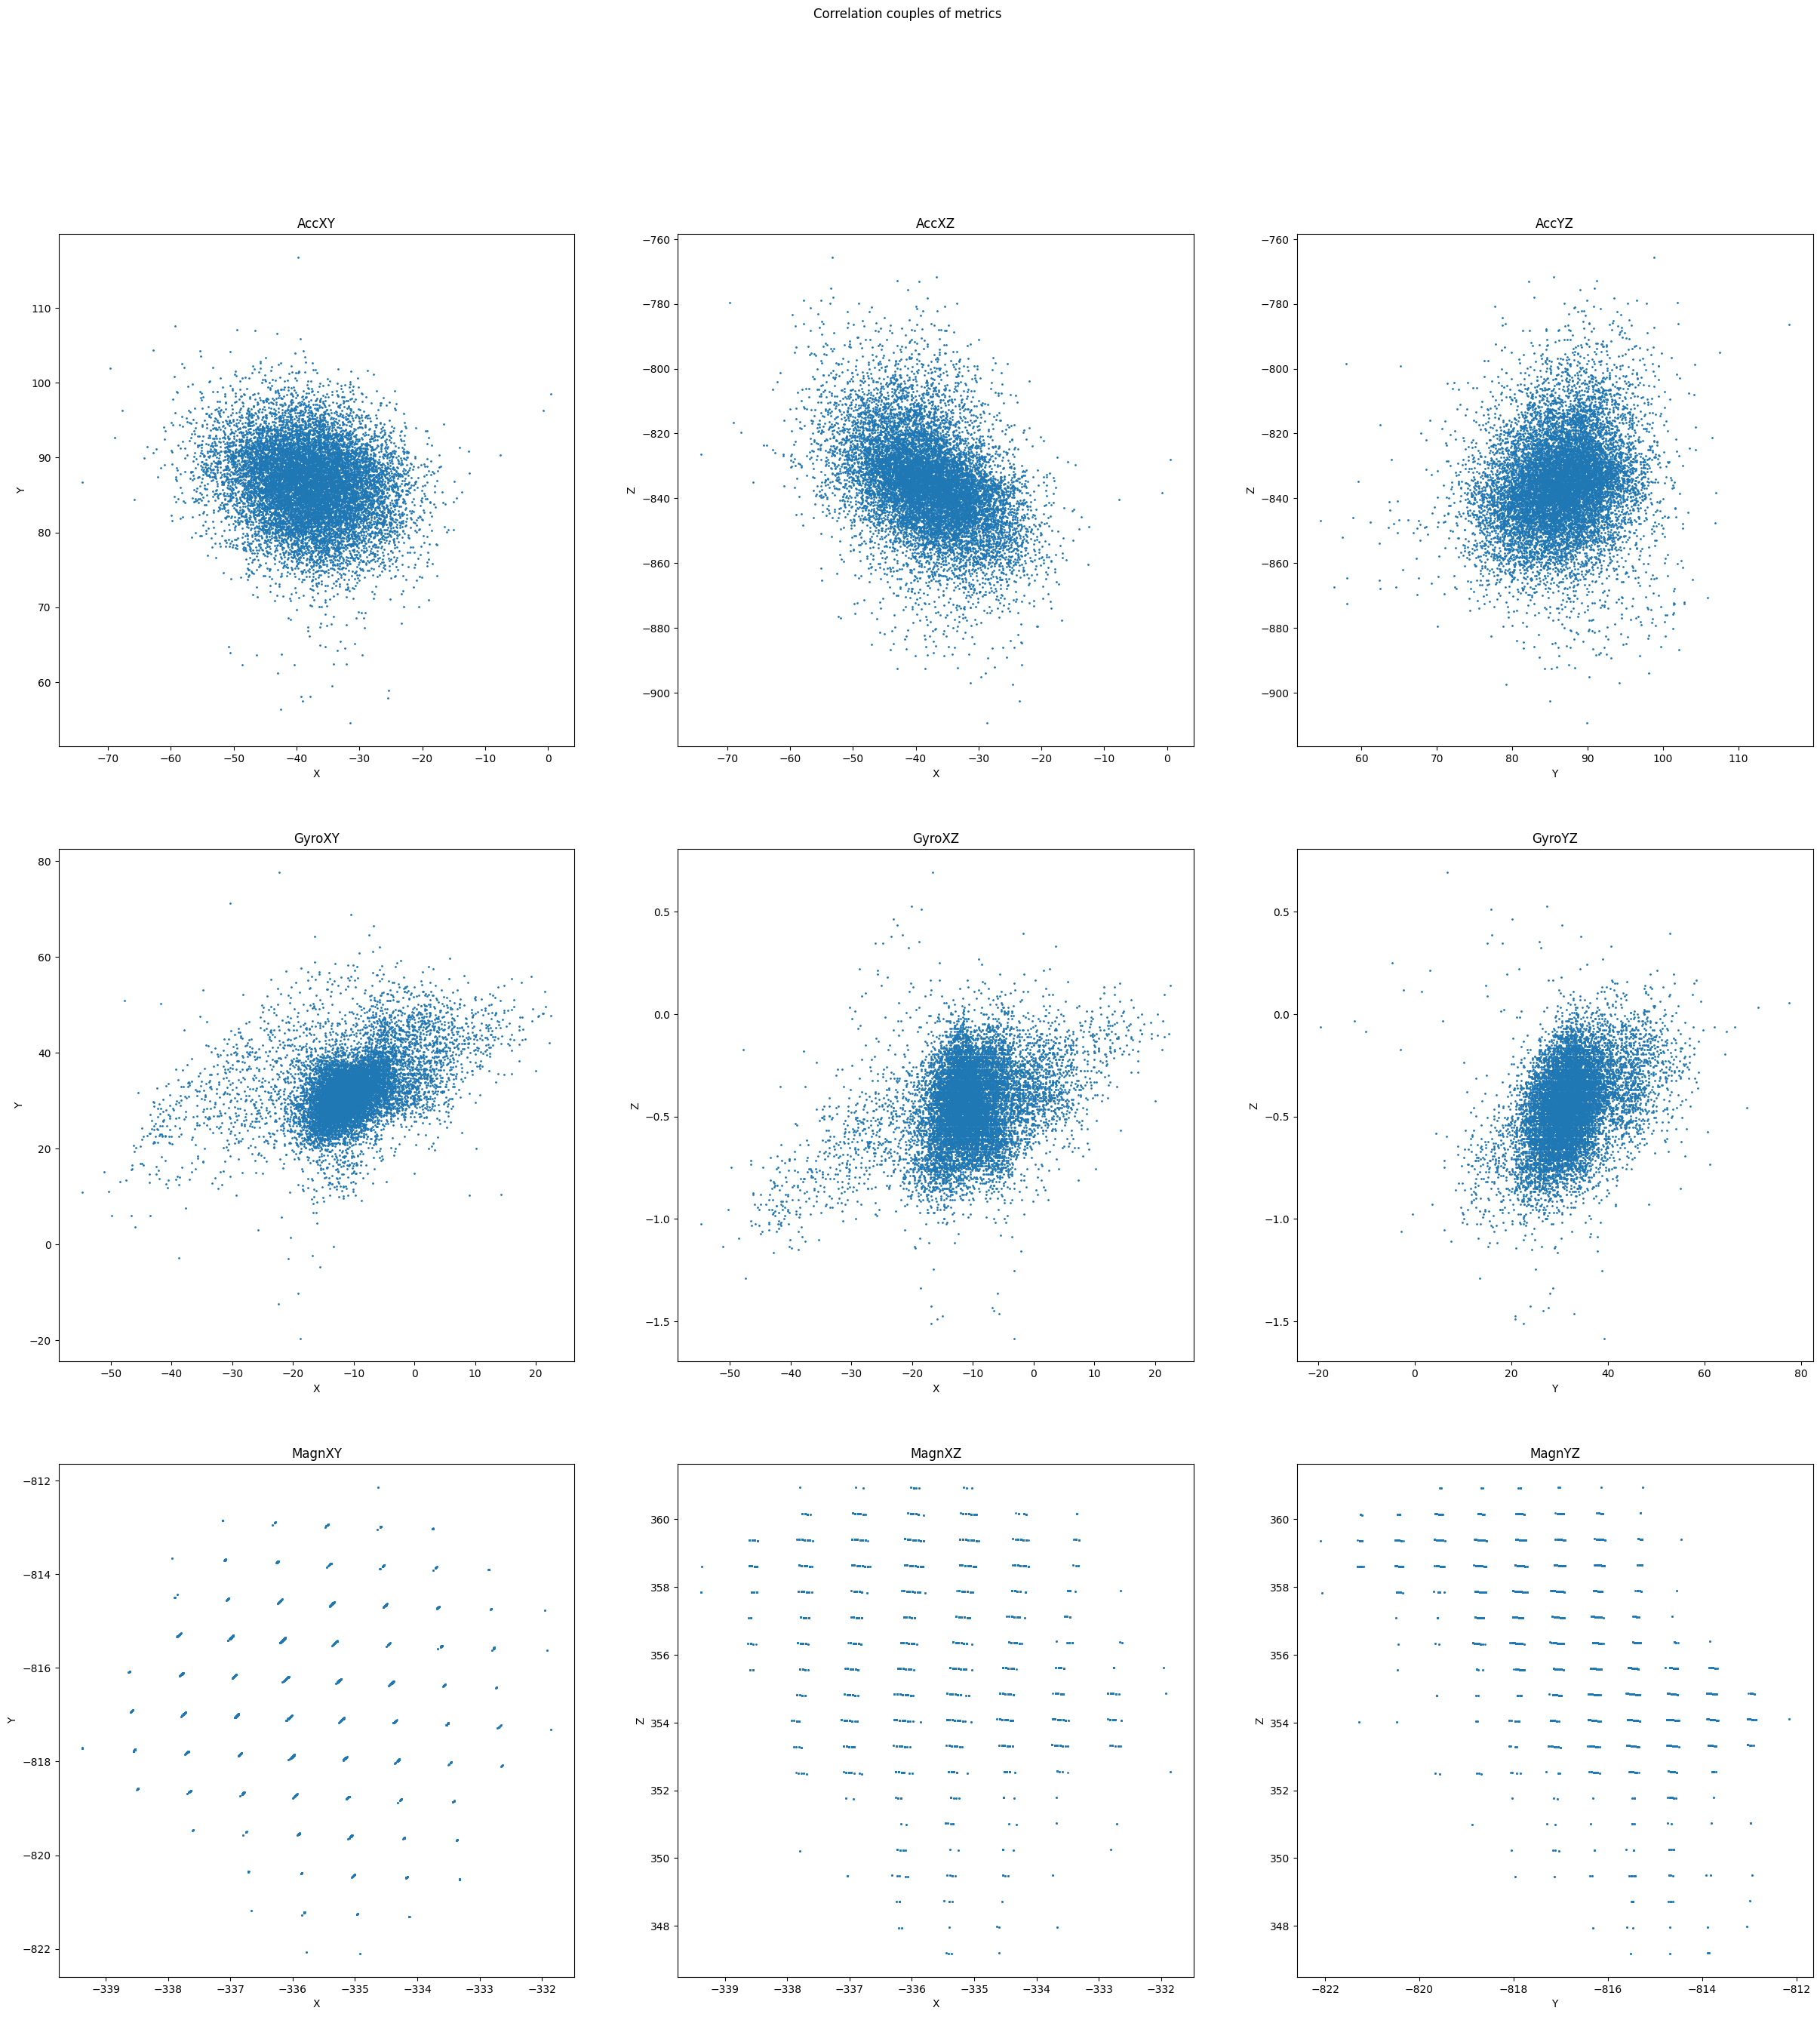

In [37]:
figure, axs = plt.subplots(3,3,figsize=(30,30))
figure.suptitle("Correlation couples of metrics")

correlationCouples = [(x,y)for x in axes for y in axes if x<y]

for index,metric in enumerate(metrics):
    for coupleIndex,couple in enumerate(correlationCouples):
        axs[index,coupleIndex].scatter(dataFrameCopy[metric+couple[0]],dataFrameCopy[metric+couple[1]],s=1)
        axs[index,coupleIndex].set_xlabel(couple[0])
        axs[index,coupleIndex].set_ylabel(couple[1])
        axs[index,coupleIndex].set_title(metric+couple[0]+couple[1])

With these 9 plots, we can't really determine a correlation between any axe for any metric.\
Considering the question, we can use a combinaison of the axes to create a new column : using the norm of each metric could be a great idea to consider a correllation.


We remind that if we have a vector $V=\begin{pmatrix} x & y & z\end{pmatrix}$, we have $||V||_1 = \sqrt{(x^2+y^2+z^2)}$.


We will use the `np.linalg.norm` method to do this, instead of creating a new method.\
Here are the graphics of the norm for each metric.

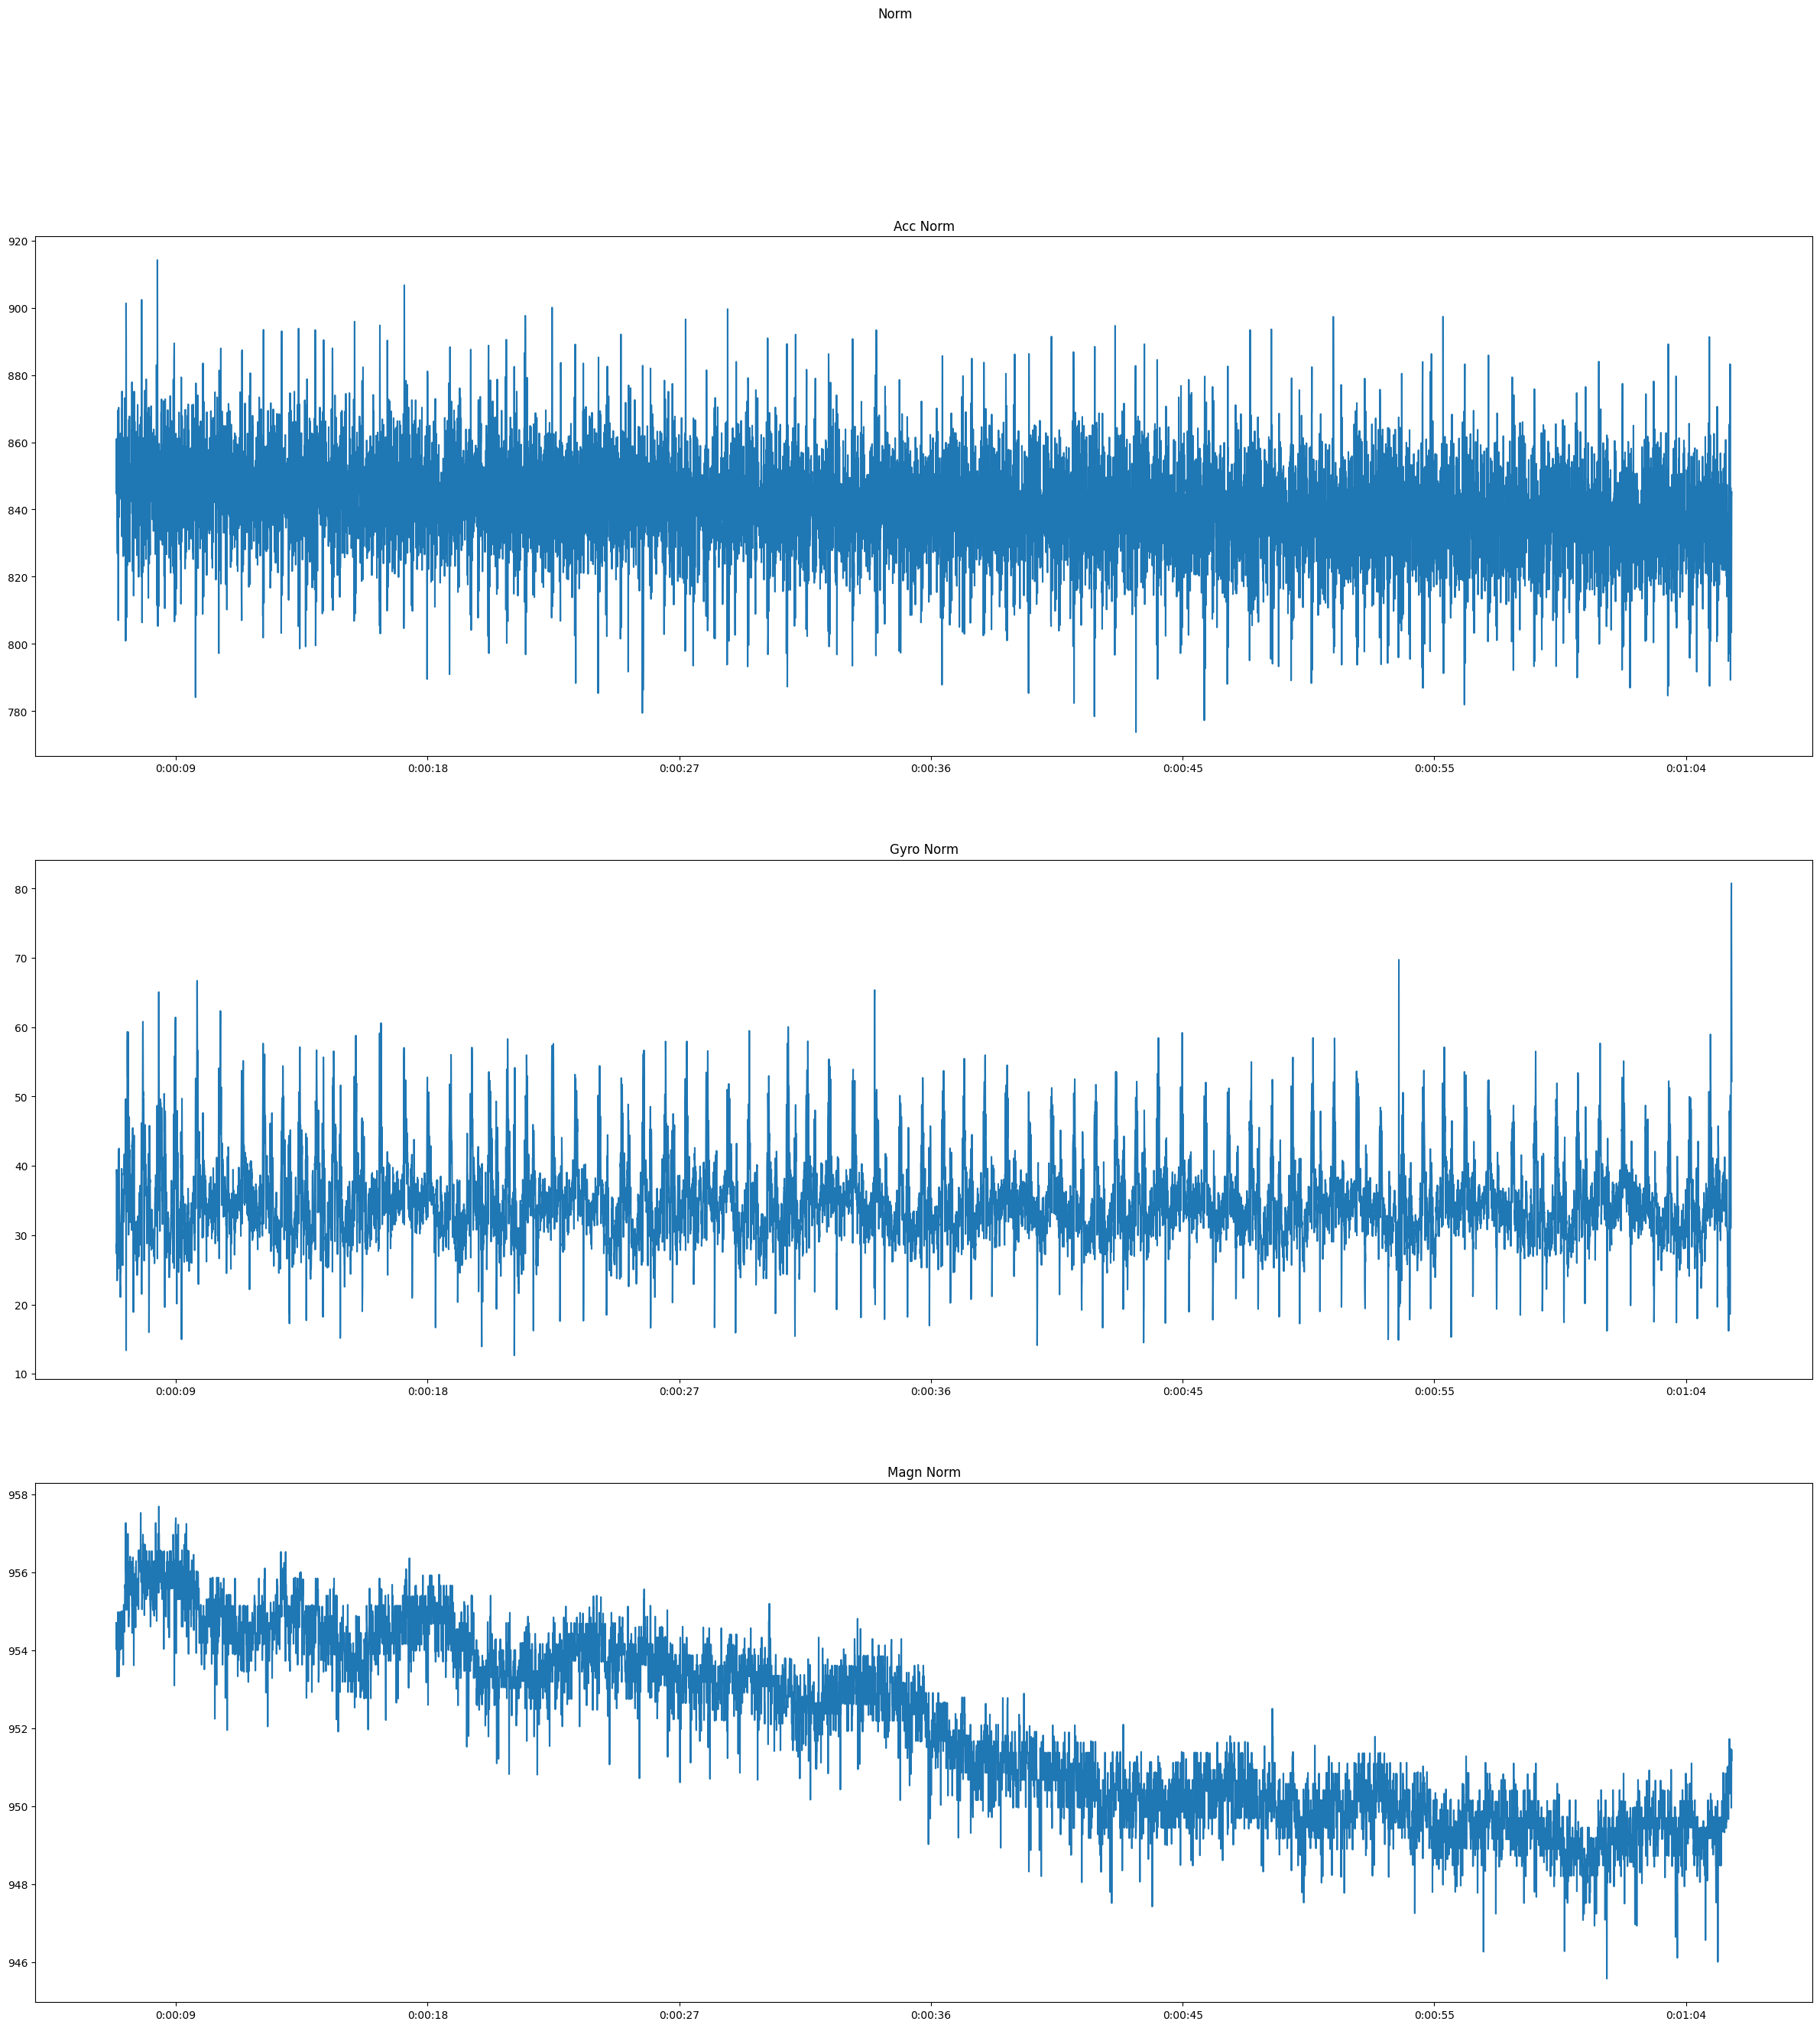

In [38]:
normAcc = dataFrameCopy[acc].apply(np.linalg.norm, axis=1)
normGyro = dataFrameCopy[gyro].apply(np.linalg.norm, axis=1)
normMagn = dataFrameCopy[magn].apply(np.linalg.norm, axis=1)

dataFrameNorm = pd.DataFrame(
    {
        "Timestamp": dataFrameCopy["Timestamp"],
        "Acc Norm": normAcc,
        "Gyro Norm": normGyro,
        "Magn Norm": normMagn,
    }
)


def graphNorm(iDataFrame, iTitle):
    values = np.arange(
        iDataFrame["Timestamp"].index.min(), iDataFrame["Timestamp"].index.max() + 1, 1
    )

    figure, axs = plt.subplots(3, figsize=(30, 30))
    figure.suptitle(str(iTitle))

    for index, metric in enumerate(metrics):
        axs[index].plot(values, iDataFrame[metric + " Norm"])
        axs[index].set_title(metric + " Norm")
        axs[index].xaxis.set_major_formatter(plt.FuncFormatter(ticks))


graphNorm(dataFrameNorm, "Norm")

To determine which axe we have to keep, we will proceed the Principal Component Analysis (PCA).\
To be more efficient, and results would be close as got by another method, we decided to use the Singular Value Decomposition (SVD) in order to proceed the PCA.

*Remark : I tried to do the same with the covariance matrix but it took way too much time compare to SVD method.*

In a first time, we do it only with axes, for each metric. Then we consider to do it with the presence of the norm in the matrix to see the difference.

In [39]:
for metric in [acc,magn,gyro]:
    matrix = np.array(dataFrameCopy[metric])
    
    _,S,Vt = linalg.svd(matrix)
    values = S**2/(matrix.shape[0]-1)
    lambdaValues = np.diag(values)

    for index,metricName in enumerate(metric):
        print("Component",metricName,"selected (without norm). Total variability :",lambdaValues[index, index]/lambdaValues.trace()*100,"%")

    norm = np.array(dataFrameCopy[metric].apply(np.linalg.norm, axis=1))
    matrix = np.c_[matrix,norm]

    _,S,Vt = linalg.svd(matrix)
    values = S**2/(matrix.shape[0]-1)
    lambdaValues = np.diag(values)

    for index,metricName in enumerate(metric):
        print("Component",metricName,"selected. Total variability :",lambdaValues[index, index]/lambdaValues.trace()*100,"%")
    print("Component norm selected. Total variability :",lambdaValues[3,3]/lambdaValues.trace()*100,"%")
    print("\n")

Component AccX selected (without norm). Total variability : 99.98758149865239 %
Component AccY selected (without norm). Total variability : 0.008599722135387254 %
Component AccZ selected (without norm). Total variability : 0.0038187792122276443 %
Component AccX selected. Total variability : 99.99379061296712 %
Component AccY selected. Total variability : 0.00429986172049803 %
Component AccZ selected. Total variability : 0.0019093898283455539 %
Component norm selected. Total variability : 1.3548404692406202e-07 %


Component MagnX selected (without norm). Total variability : 99.99955045868495 %
Component MagnY selected (without norm). Total variability : 0.0003201589958783084 %
Component MagnZ selected (without norm). Total variability : 0.00012938231917680954 %
Component MagnX selected. Total variability : 99.99977522918603 %
Component MagnY selected. Total variability : 0.00016007950013356836 %
Component MagnZ selected. Total variability : 6.469115964022554e-05 %
Component norm select

We can see, in every metric and in every case, that the $X$-axe is the most important to retain a maximum of variability. For the rest of the study, we will only consider the $X$-axe for the different metrics.

2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

In [40]:
xAxes = [metric+"X" for metric in metrics]
dataFrameXaxes = dataFrameCopy[xAxes].copy()
print(dataFrameXaxes.describe())

               AccX         GyroX         MagnX
count  12838.000000  12838.000000  12838.000000
mean     -37.973132    -10.565966   -335.714085
std        7.127615      7.291190      1.103859
min      -74.138296    -54.727597   -339.380406
25%      -42.611453    -13.585948   -336.205262
50%      -37.926076    -10.822706   -335.949076
75%      -33.237828     -7.368651   -335.103438
max        0.491967     22.489732   -331.855321


These are the statistical information. Mean and standard deviation are more meaningful than other as we can perfectly understand them and interprete their values.

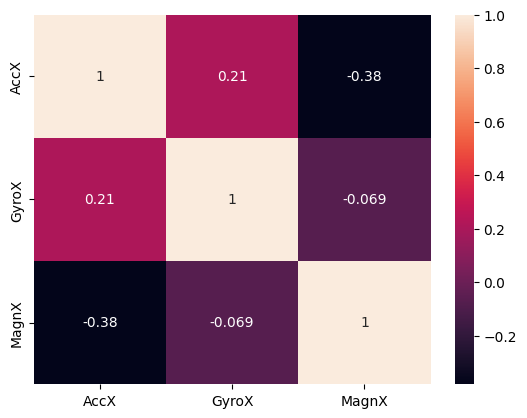

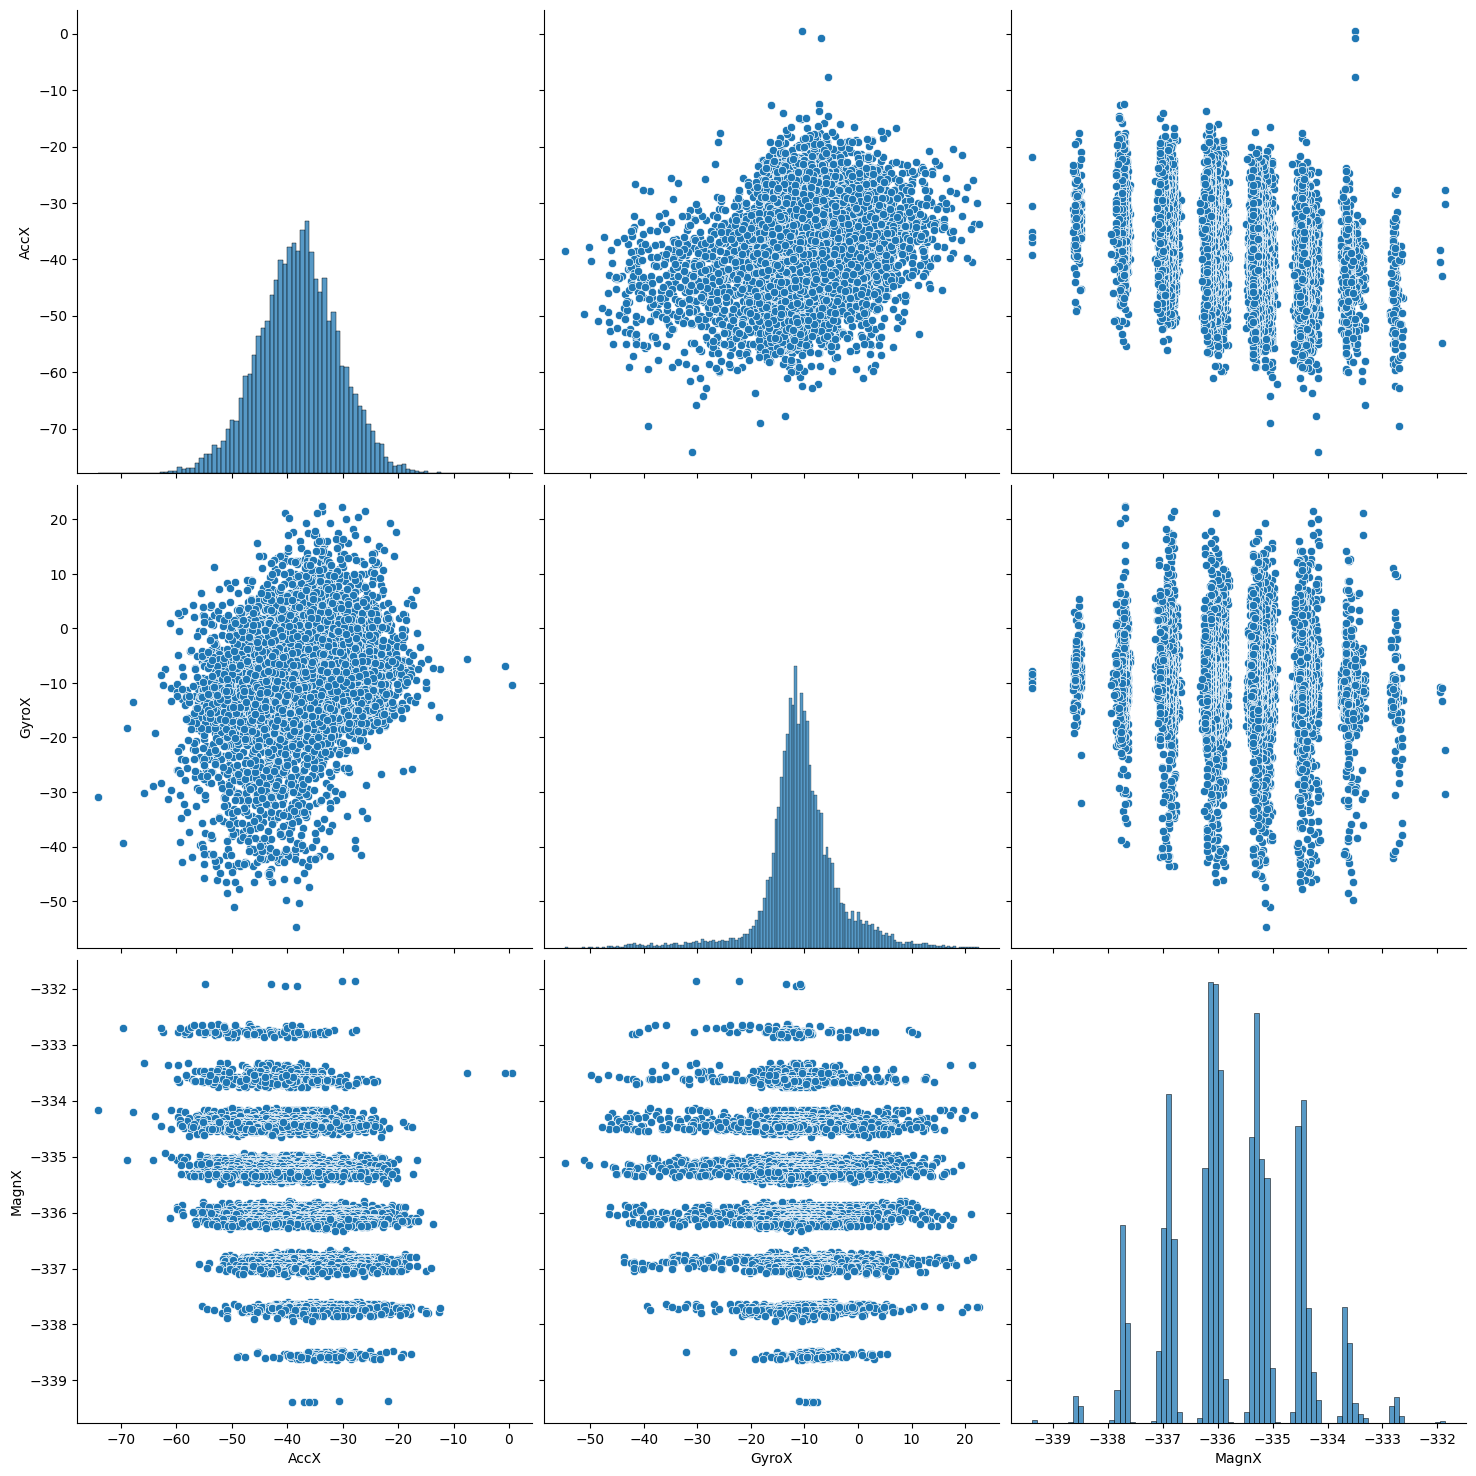

In [41]:
sns.heatmap(dataFrameXaxes.corr(), annot=True )
sns.pairplot(dataFrameXaxes,height=5)

As we noticed for each couple of axe, we don't really observ a pattern of correlation : we can't affirm metrics are correlated.


2. Time and frequency analysis:

    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use the Fourier analysis to properly design the filters in the following step. 



In [42]:
def filteredSignal(iSignal):
    fftSignal = np.abs(fftpack.fft(iSignal))
    freq = fftpack.fftfreq(len(fftSignal), d=1 / 200)
    maxFreq = np.abs(freq[freq > 0]).max()
    fftSignal[np.abs(freq) - maxFreq > 0] = 0
    # return [freq[fftSignal[freq > 0].argmax() + 1], freq[freq > 0], fftSignal[freq > 0]]
    return [freq[freq > 0], fftSignal[freq > 0]]

*Remark : in the method `fftpack.fftfreq`, `d` represents the sample spacing, which is the inverse of a frequency. But if you remind well, we have a static frequency of capture in the dataframe, which was equal to 200 (it's the `Log Freq` column). That's explain the `1/200` value.*

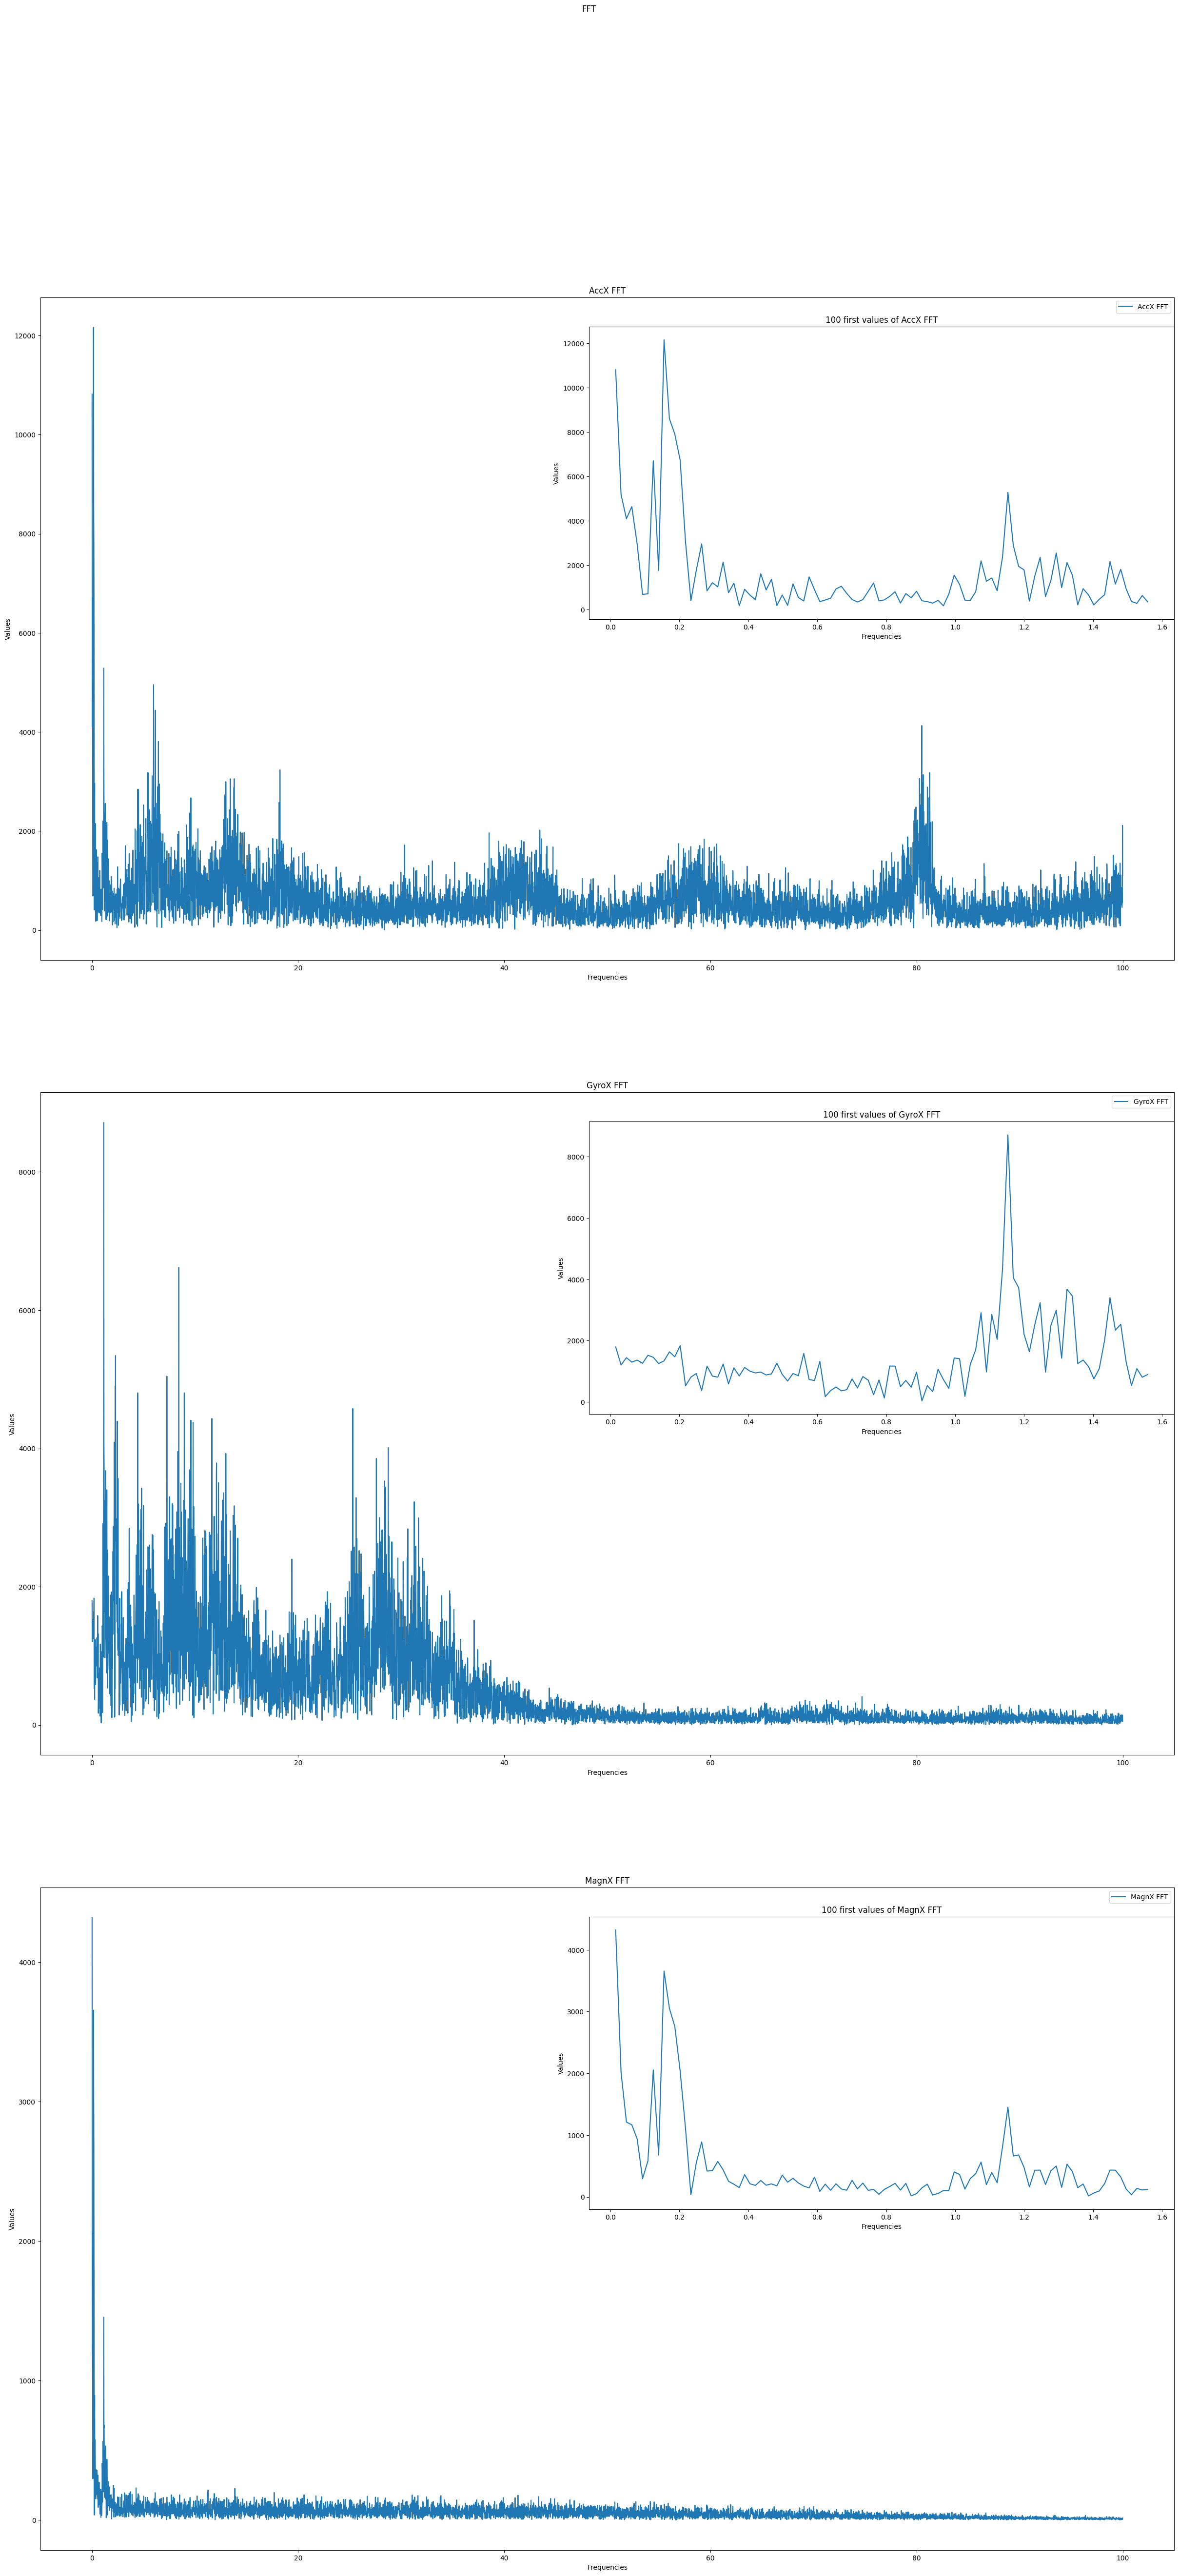

In [43]:

figure, axs = plt.subplots(3, figsize=(30, 60))
figure.suptitle("FFT")

for index, xAxe in enumerate(xAxes):
    freq, values = filteredSignal(dataFrameXaxes[xAxe].values)

    axs[index].plot(freq, values, label=xAxe+" FFT")
    axs[index].set_title(xAxe + " FFT")
    axs[index].set_xlabel("Frequencies")
    axs[index].set_ylabel("Values")
    axs[index].legend()

    pos = axs[index].get_position()
    ax_sub = figure.add_axes([pos.x1 - 0.4, pos.y1 - 0.11, 0.4, 0.1])
    ax_sub.plot(freq[:100], values[:100], label=xAxe)
    ax_sub.set_xlabel("Frequencies")
    ax_sub.set_ylabel("Values")
    ax_sub.set_title("100 first values of " + xAxe + " FFT")

Lack of time to plot each metric supperposed with FFT values.\
Nevertheless, we can notice if we zoom on the beginning of each graphic, we can see a peak among values, and other are really low to it : maybe we can consider that this peak can have an influence.\
Lack of interpretation : to be done/completed.



3. Filter:
    
    Implement your own filter, trying to extrapolate the heart rate signal. Hints:
    
    (a) Directly from Fourier Analysis, look for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
        
    (c) Explore another methods by yourselves.
    
    Remember to always motivate your choice.
    
    


4. Metrics:

    4.1. Heart Beat Per Minute (BPM): extrapolate BPM, make an histogram of the result. Does it follow a particular distribution? 
    
    4.2. Heart Rate Variability (HRV): extrapolate HRV, explain why this parameter is important, and plot the results.




5. **Optional**: Elaborate a simple algorithm to extrapolate the heart rate even when the filter fails (e.g. look for a particular threshold...).  





6. Conclusion: 

    Summarise the obtained results, and specifically make a comparison between the two files analysed. Highlight the limitations and the critical issues encountered during the work, motivating the most relevant contribution given by your solution.